# Анализ убытков приложения Procrastinate Pro+

На основе данных о пользователях, привлеченных с 1 мая по 27 октября 2019 года, выявить возможные причины убытков и дать рекомендации, чтобы компания вышла в плюс. 

***Задачи проекта (ответить на вопросы):***
- Из каких источников приходят пользователи и какими устройствами они пользуются?
- Сколько стоит привлечение пользователей из различных рекламных каналов?
- Сколько денег приносит каждый клиент?
- Когда расходы на привлечение клиента окупаются?
- Какие факторы мешают привлечению клиентов?

***Цели проекта:***
- Выявить причины, почему не смотря на огромные вложения в рекламу, компания терпит убытки
- Дать рекомендации компании, как выйти в плюс.

## Общая информация и предработка данных

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import date,datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [62]:
sessions = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

In [63]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [64]:
sessions.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [65]:
#переименование столбцов к нижнему регистру
sessions = sessions.rename(columns = {'User Id' : 'user_id', 'Region':'region',
                                 'Device':'device', 'Channel':'channel', 'Session Start':'session_start',
                                 'Session End' : 'session_end'})

In [66]:
sessions.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [67]:
#приведение столбцов с датой и временем к типу "дата"
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions['session_end'] = pd.to_datetime(sessions['session_start'])

In [68]:
# проверка, что в датафрейме sessions нет дубликатов
sessions.duplicated().sum() 

0

In [69]:
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [70]:
#переименование столбцов к нижнему регистру
orders = orders.rename(columns = {'User Id' : 'user_id', 'Event Dt':'event_dt',
                                 'Revenue':'revenue'})

In [71]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [72]:
#проверка, что в датафрейме orders нет дубликатов
orders.duplicated().sum()

0

In [73]:
print(costs.info())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [74]:
#переименование столбцов к нижнему регистру
costs = costs.rename(columns = {'Channel' : 'channel'})

In [75]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [76]:
# проверка, что нет дубликатов
costs.duplicated().sum() 

0

***Вывод***

Сначала были загружены данные, и на этапе предработке данных были проверены на дубликаты. В данных дубикатов не оказалось. Также я привела названия столбцов к нижнему регистру для удобсвта в дальнейшем исследовании и данные с датами были приведены к типу datetime.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Задание функций для рачета и анализа LTV, ROI,удержания и конверсии:
- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.
- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [77]:
#функция для создания профилей пользователей
def get_profiles(sessions, orders, ad_costs):
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id')
                        .agg({'session_start' : 'first', 'channel': 'first',
                              'device': 'first', 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()                                           
               )
   
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
   
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], 
                              on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) 
    
    return profiles

In [78]:
#функция для подсчёта Retention Rate
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [79]:
#функция для подсчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [80]:
# функция для подсчёта LTV
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw, 
        result_grouped, 
        result_in_time, 
        roi_grouped,  
        roi_in_time,  
    )

In [81]:
# функция для сглаживания фрейма

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [82]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [83]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [84]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

На данном этапе нужно:
- Составить профили пользователей. 
- Определить минимальную и максимальную даты привлечения пользователей.
- Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 
- Построить таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Выявить, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
- Построить таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучить рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. 
- Построить таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.


In [85]:
#таблица профилей пользоватеей
profiles = get_profiles(sessions, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
114488,763007207455,2019-09-28 10:30:18,FaceBoom,Android,United States,2019-09-28,2019-09-01,False,1.125095
74143,491954303102,2019-05-06 10:01:28,organic,Android,UK,2019-05-06,2019-05-01,False,0.000000
41591,275818963759,2019-08-16 21:44:49,FaceBoom,Android,United States,2019-08-16,2019-08-01,False,1.110628
90489,602023605662,2019-07-23 13:52:00,FaceBoom,PC,United States,2019-07-23,2019-07-01,False,1.127273
31678,210467836622,2019-08-04 20:54:02,lambdaMediaAds,iPhone,France,2019-08-04,2019-08-01,False,0.720000


In [86]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [87]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

***Вывод***\
Я определила период, за который люди совершали первое посещение. Самое первое посещение было 1 мая 2019 года, а самое последнее посещение 27 октября 2019 года. В период ***с 1 мая по 28 октября 2019 года*** пользователи совершали первое посещение.

In [120]:
country = profiles.groupby('region').agg({'user_id':'nunique', 'payer':'sum'}).reset_index()
country

,region,user_id,payer
0,France,11058,554
1,Germany,9528,490
2,UK,11154,569
3,United States,61829,6108


***Вывод***\
Пользователи приходят в приложение из стран Франции, Германии, Великобритании, США. По данных видно, что из США больше всего платящих пользователей.

In [89]:
country['half'] = country['payer']/country['user_id']
country = country.drop(['user_id'], axis=1)
country = country.drop(['payer'], axis=1)
country['half'].sort_values(ascending=False)

region
United States    0.069019
Germany          0.041119
UK               0.039829
France           0.037994
Name: half, dtype: float64

***Вывод***\
Самая большая доля платящих пользователей в США, потом идет Германия, Великобритании, Франции.

In [90]:
device = profiles.groupby('device').agg({'user_id':'nunique', 'payer':'sum'}).reset_index()
device

,user_id,payer
device,,
Android,35032,2050
Mac,30042,1912
PC,30455,1537
iPhone,54479,3382


***Вывод***\
Клиенты пользуются Android, Mac, PC, iPhone. Платящие пользователи предпочитают iPhone.

In [91]:
device['half'] = device['payer']/device['user_id']
device= device.drop(['user_id'], axis=1)
device = device.drop(['payer'], axis=1)
device['half'].sort_values(ascending=False)

device
Mac        0.063644
iPhone     0.062079
Android    0.058518
PC         0.050468
Name: half, dtype: float64

***Вывод***\
Самая большая доля платящих пользователей пользуются Mac, потом iPhone, дальше идет Аndroid, а в конце PC. 

In [92]:
advertisement = profiles.groupby('channel').agg({'user_id':'nunique', 'payer':'sum'})
advertisement.sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,3557
TipTop,19561,1878
organic,56439,1160
WahooNetBanner,8553,453
AdNonSense,3880,440
RocketSuperAds,4448,352
LeapBob,8553,262
OppleCreativeMedia,8605,233
lambdaMediaAds,2149,225


***Вывод***\
Большая часть платящих пользоватлей приходит из канала рекламы ***FaceBoom***, дальше идутт:
- TipTop, 
- organic, 
- WahooNetBanner,
- AdNonSense, 
- RocketSuperAds, 
- LeapBob,
- OppleCreativeMedia,
- lambdaMediaAds,
- YRabbit,
- MediaTornado

In [93]:
advertisement['half'] = advertisement['payer']/advertisement['user_id']
advertisement = advertisement.drop(['user_id'], axis=1)
advertisement = advertisement.drop(['payer'], axis=1)
advertisement['half'].sort_values(ascending=False)

channel
FaceBoom              0.122049
AdNonSense            0.113402
lambdaMediaAds        0.104700
TipTop                0.096007
RocketSuperAds        0.079137
WahooNetBanner        0.052964
YRabbit               0.038265
MediaTornado          0.035747
LeapBob               0.030633
OppleCreativeMedia    0.027077
organic               0.020553
Name: half, dtype: float64

***Вывод***\
Самая большую долю платящих клиентов приносит ***FaceBoom***, потом идут 
- AdNonSense,
- lambdaMediaAds,
- TipTop,
- RocketSuperAds,
- WahooNetBanner,
- YRabbit,
- MediaTornado,
- LeapBob, 
- OppleCreativeMedia, 
- organic. 

### Маркетинг

- Подсчет общей суммы расходов на маркетинг.
- Выяснить, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построить визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
- Узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.


In [94]:
print('Общая сумма расходов на маркетинг')
costs['costs'].sum()

общая сумма расходов на маркетинг


105497.30000000002

In [95]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Общая сумма расходов на маркетинг превышает 100000

In [96]:
adv = costs.groupby('channel').agg({'costs':'sum'}).reset_index()
adv.sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Больше всего потратила компания TipTop. А меньше компания YRabbit

In [97]:
# добавление столбцов с номером недели и месяца
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

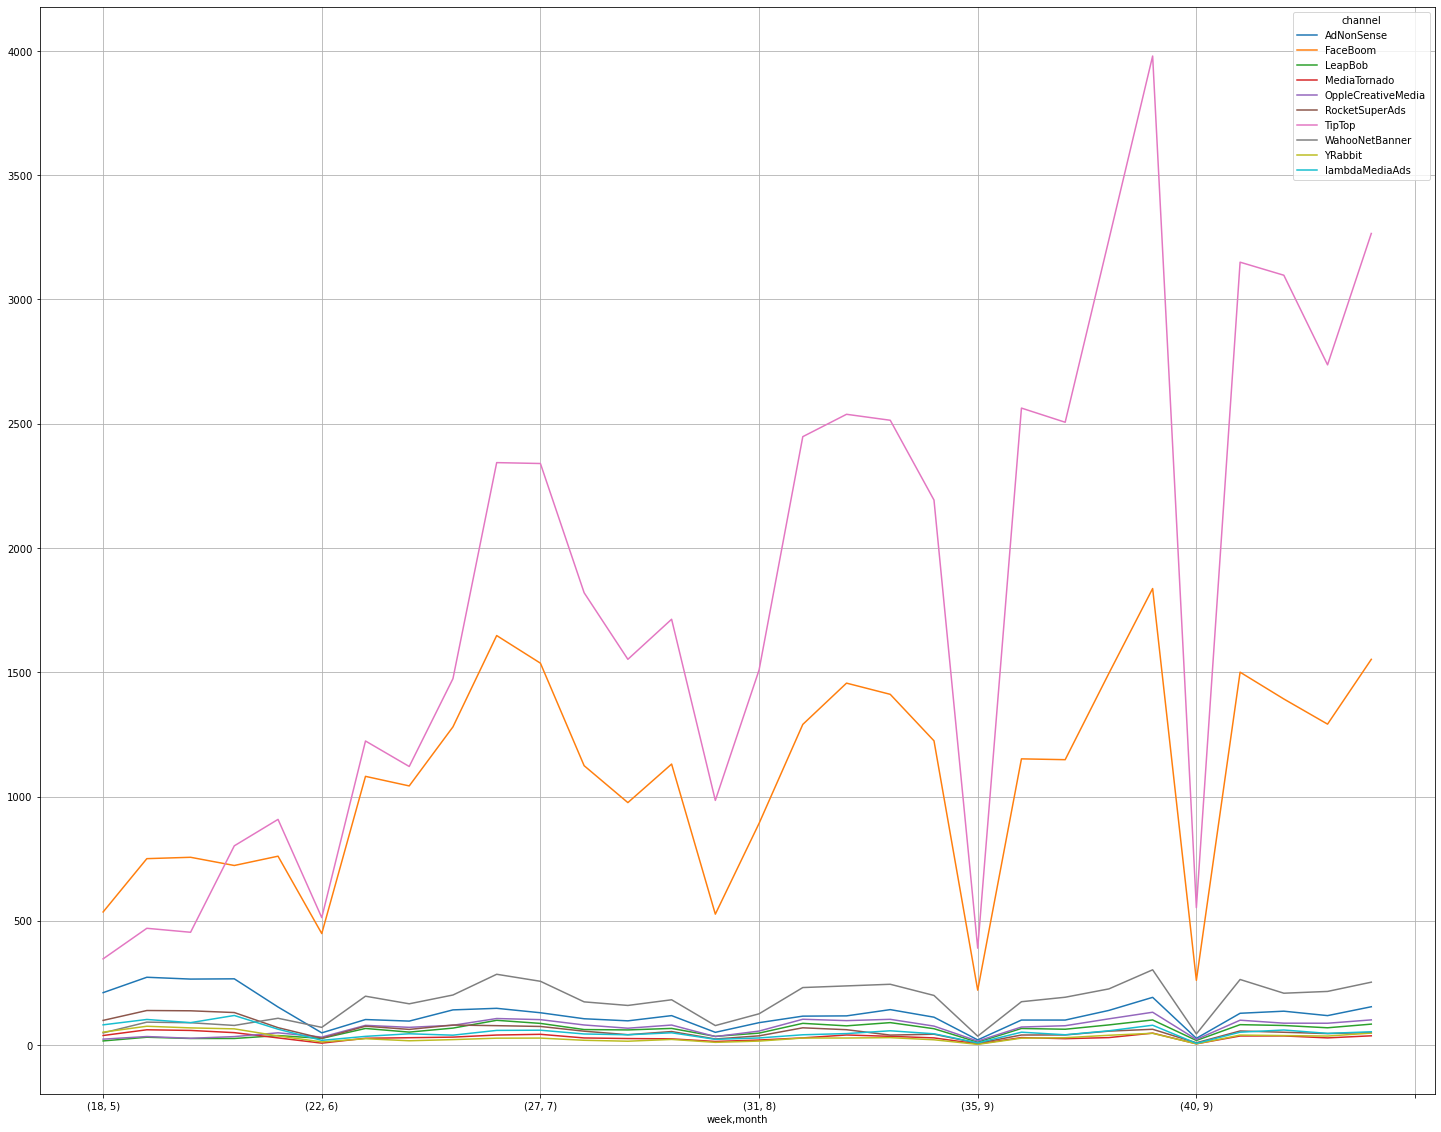

In [123]:
costs.pivot_table(index=['week','month'], 
                  columns='channel', 
                  values='costs', 
                  aggfunc='sum').plot(figsize=(25,20), grid=True);

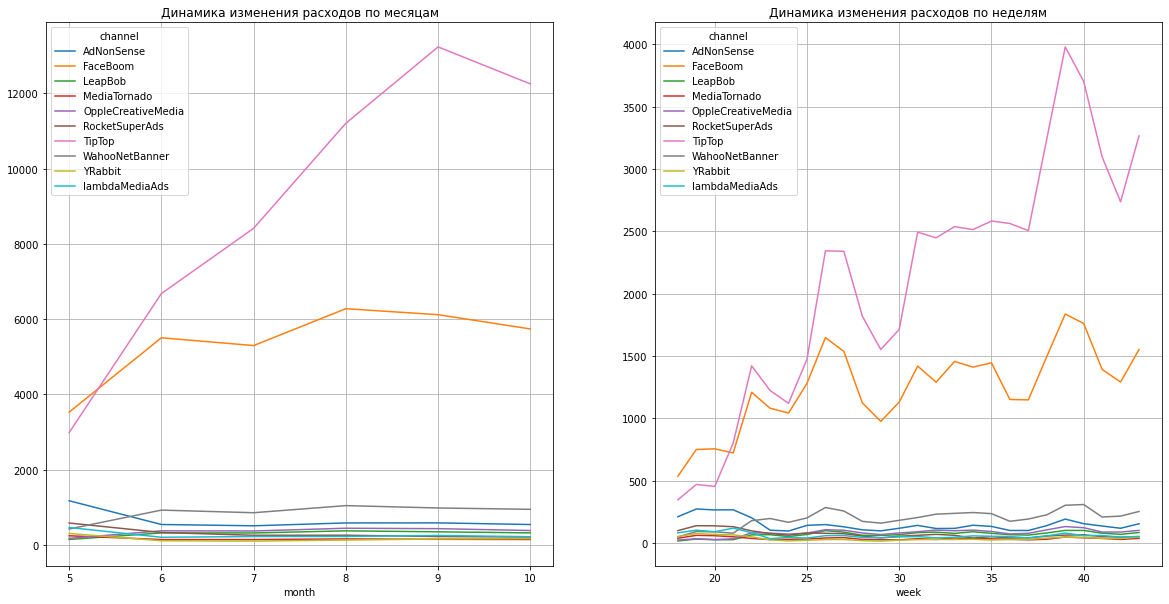

In [99]:
plt.figure(figsize = (20, 10))
costs.pivot_table(index='channel',
                  columns='month', 
                  values='costs', 
                  aggfunc='sum').T.plot(ax=plt.subplot(1, 2, 1),grid = True);
plt.title('Динамика изменения расходов по месяцам')
costs.pivot_table(index='channel',
                  columns='week', 
                  values='costs', 
                  aggfunc='sum').T.plot(ax=plt.subplot(1, 2, 2),grid = True);
plt.title('Динамика изменения расходов по неделям');

***Вывод***\
По графикам видно, что компания ***Tip Top*** с каждым месяцем увеличивает свои расходы, кроме последнего месяца. Компания ***FaceBoom*** идет на втором месте по расходам. 
Все остальные компании стабильны по расходам.

In [100]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [101]:
r = profiles.groupby('channel').agg({'user_id':'nunique', 'acquisition_cost':'sum'})
r['CAC'] = r['acquisition_cost'] / r['user_id']
r = r.drop(['user_id'], axis=1)
r = r.drop(['acquisition_cost'], axis=1)
r['CAC'].sort_values(ascending=False)


channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic               0.000000
Name: CAC, dtype: float64

***Вывод***\
Самое дорогое привлечение одного клиента стоило у компании Tip Top, дальше идет FaceBoom, на третьем месте идет компания AdNonSense.

### Оценка окупаемости рекламы

План окупаемости рекламы:
- Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.
- Проверка конверсии пользователей и динамику её изменения. 
- Анализ удержания пользователей. 
- Построение и изучение графиков конверсии и удержания.
- Анализ окупаемости рекламы с разбивкой по устройствам. 
- Построение графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.
- Анализ окупаемости рекламы с разбивкой по странам.
- Построение графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.
- Анализ окупаемости рекламы с разбивкой по рекламным каналам. 
- Построение графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.


Уберу органических пользователей, так как они приходят в компанию самостоятельно

In [102]:
profiles = profiles[~(profiles['channel'] == 'organic')]

In [103]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
...,...,...,...,...,...,...,...,...,...
149999,999942424543,2019-05-24 21:03:26,TipTop,iPhone,United States,2019-05-24,2019-05-01,False,1.900000
150001,999949280903,2019-08-12 06:47:27,FaceBoom,Mac,United States,2019-08-12,2019-08-01,False,1.117838
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000


Чтобы проанализировать окупаемость пользователей не позднее чем за 2 недели привлечения,\
то возьму дату момента анализа = 1 ноября и горизонт анализа = 14 дням.

In [104]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

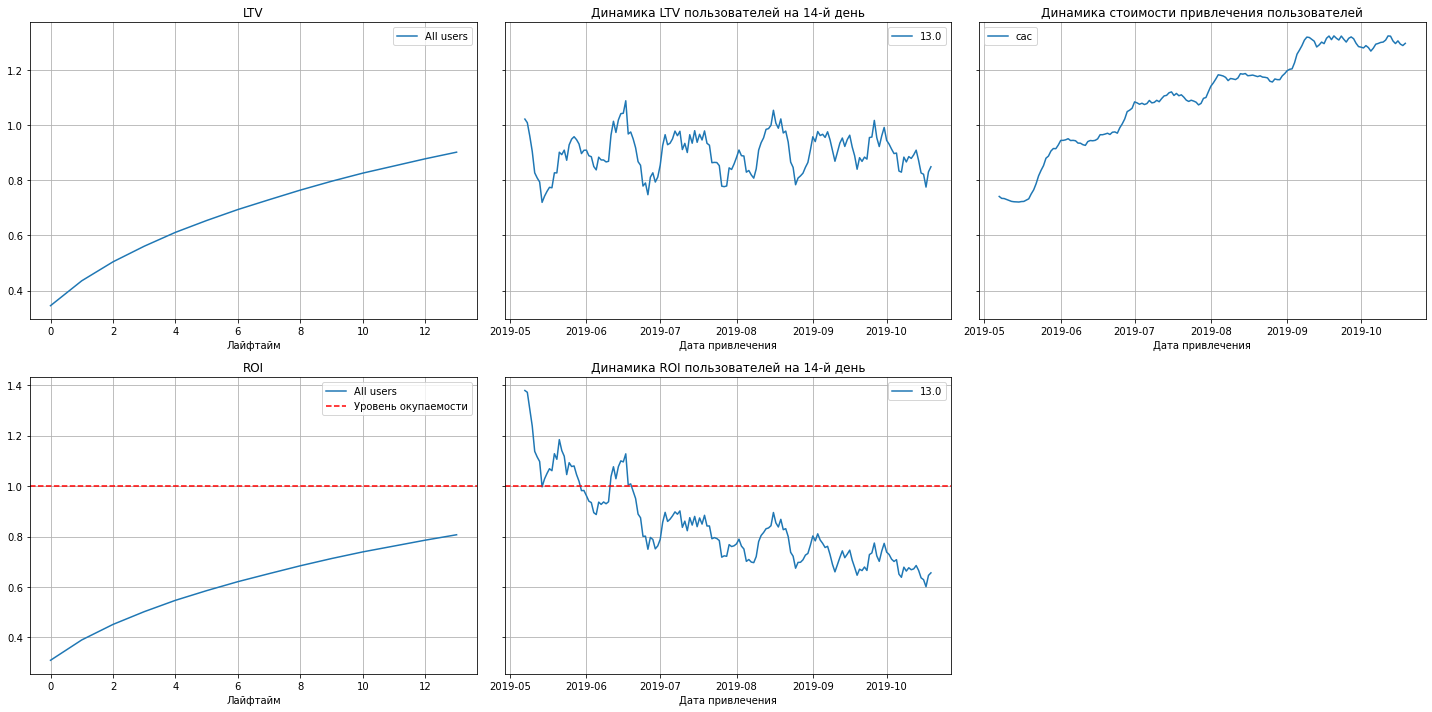

In [105]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles,
                                                                      orders,
                                                                      observation_date,
                                                                      horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

***Вывод***
- ROI не доходит до окупаемости
- Компания перестает окупаться уже в июле
- СAC растет на всем промежутке
- LTV постепенно растет

In [106]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days)

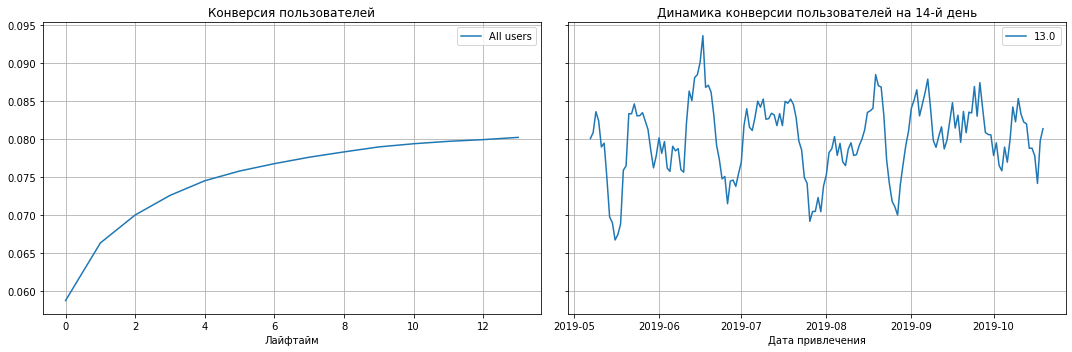

In [107]:
plot_conversion(conversion, conversion_history, horizon_days)

***Вывод***\
Конверсия стала останавливаться от 6 дня лайфтайма

In [108]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days
)

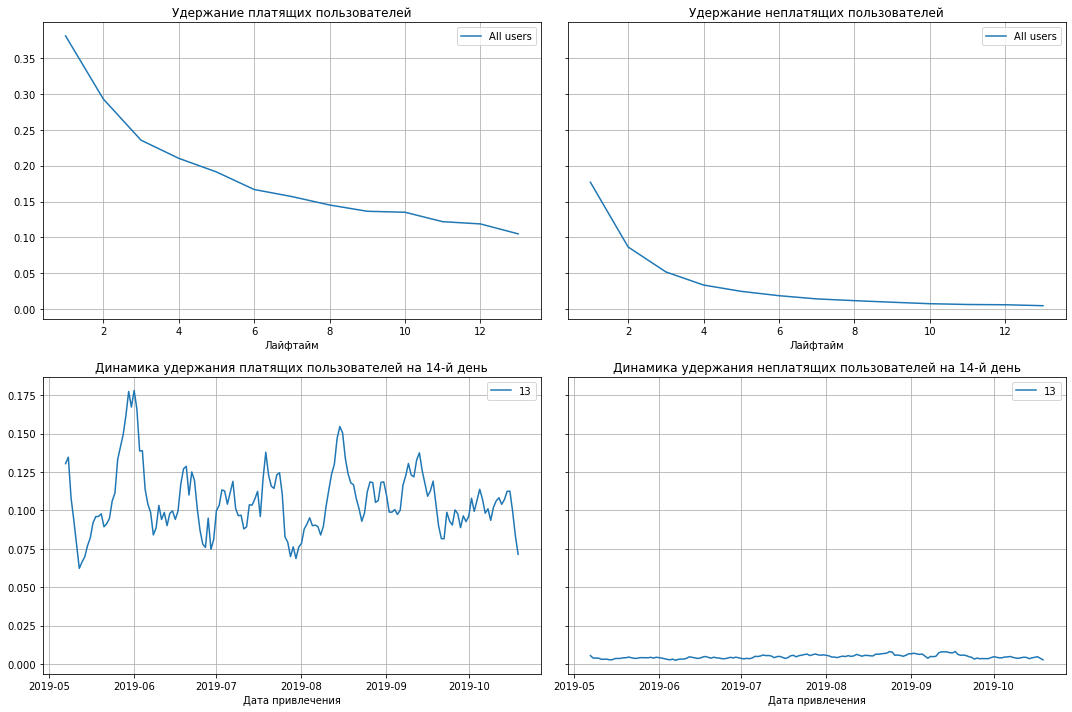

In [109]:
plot_retention(retention, retention_history, horizon_days)

Разбивка по устройствам 

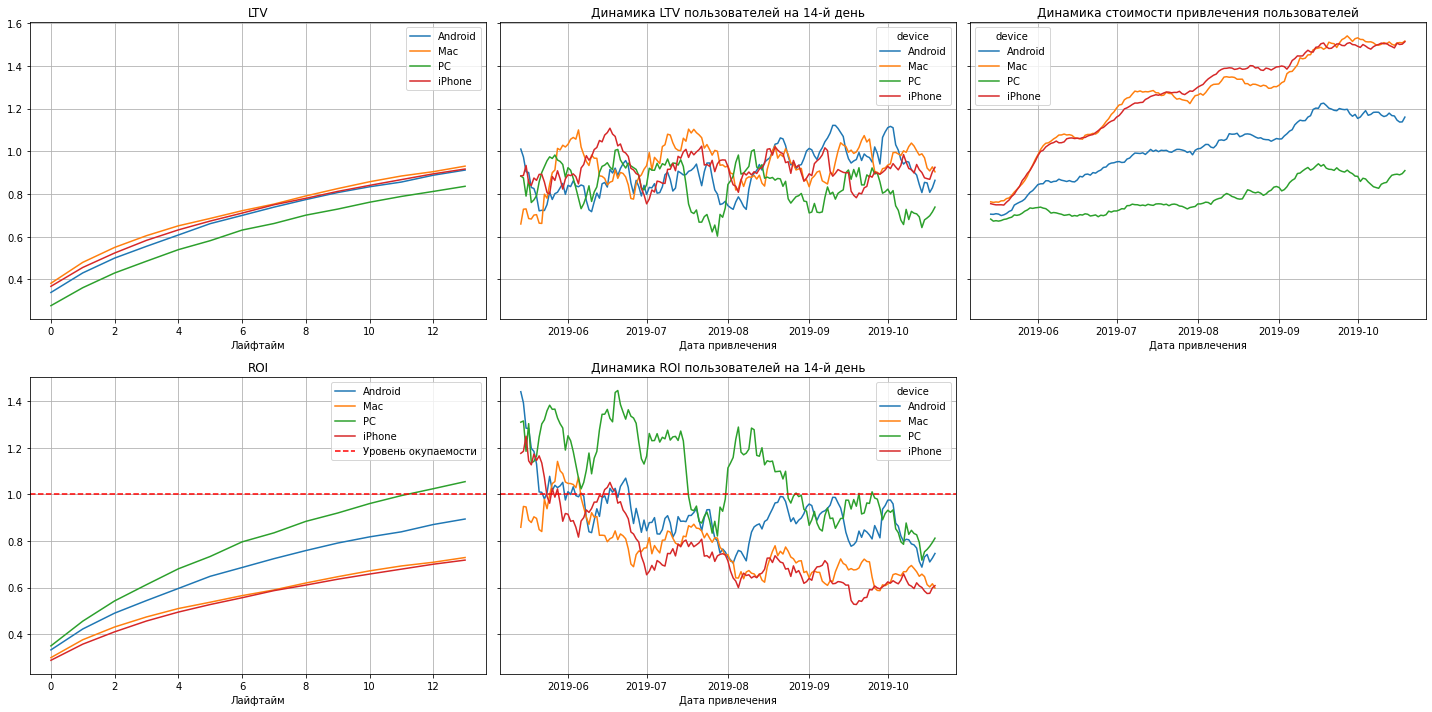

In [110]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 



***Вывод*** 
- Реклама окупается только на устройстве PC, а на остальных устройтсвах не окупаются.
- Стоимость привлечения сильно различается в разные месяцы, больше всего у iPhone, Mac.
- LTV почти стабилен на всех устройствах

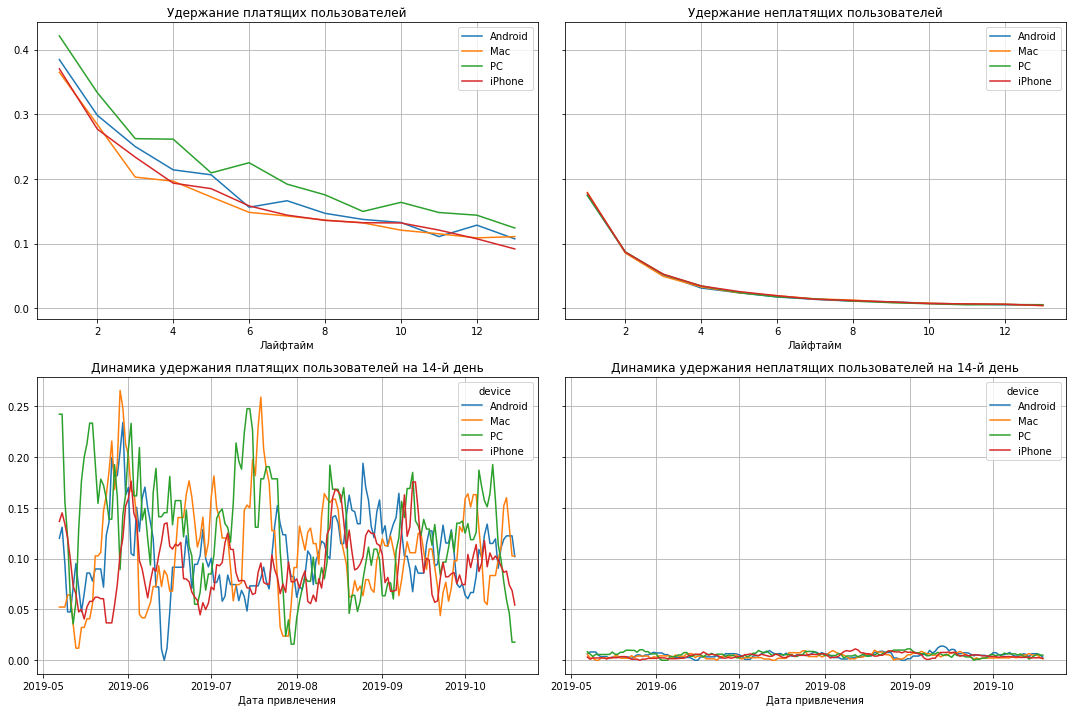

In [111]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
plot_retention(retention, retention_history, horizon_days)

***Вывод***
- Удежание неплатящих пользователей почти одинаков.
- Динамика удержания неплатящих пользователей примерно одинаковая.
- Удержание платящих пользователей выше всех на устройстве PC.

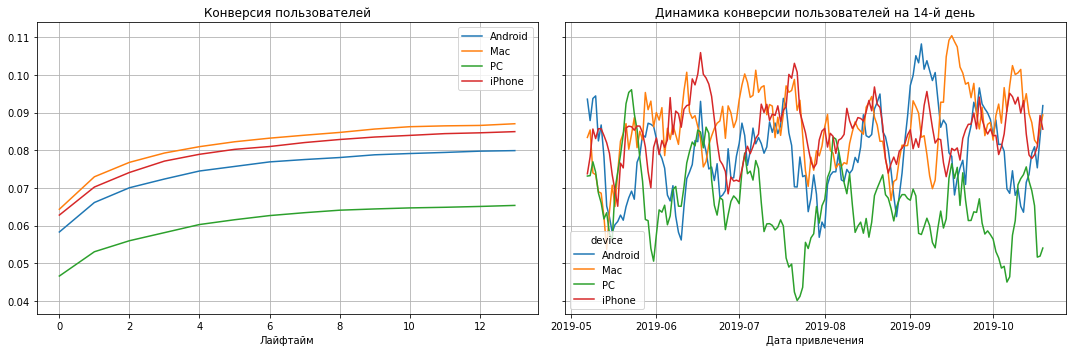

In [112]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days, dimensions=dimensions)
plot_conversion(conversion, conversion_history, horizon_days)

***Вывод***
- Конверсия хуже всех на устройстве PC и Android.
- Конверсия выше всех на устройстве Mac.

Разбивка по странам

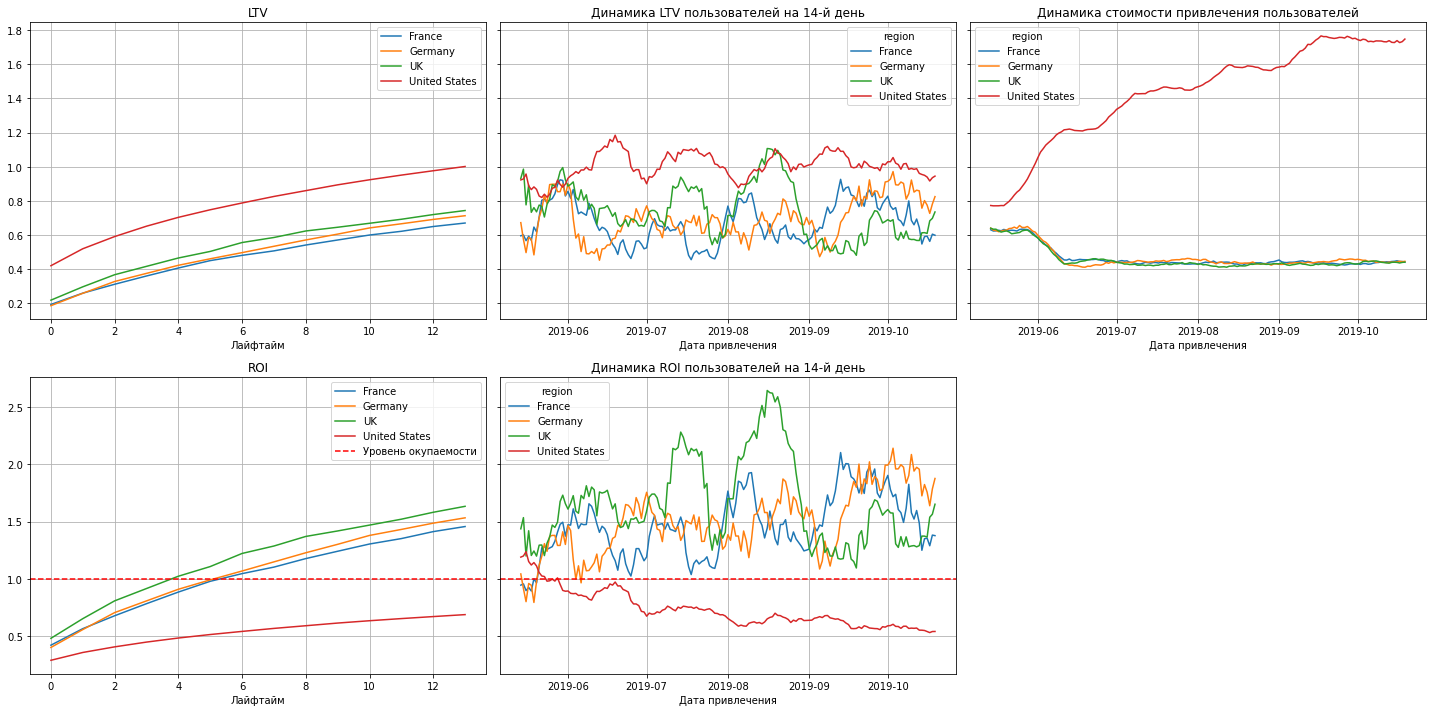

In [113]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

***Вывод***
- Самый больший LTV у США. Динамики у отсальных почти одинакови стабилен.
- Динамика стоимости с мая у США повышается, у остальных стран понижается и с июня стабилен.
- Окупаемость прошла у Франции, Германии, Великобритании. У США не прошел уровень окупаемости
- Динамика ROI у США понижается.


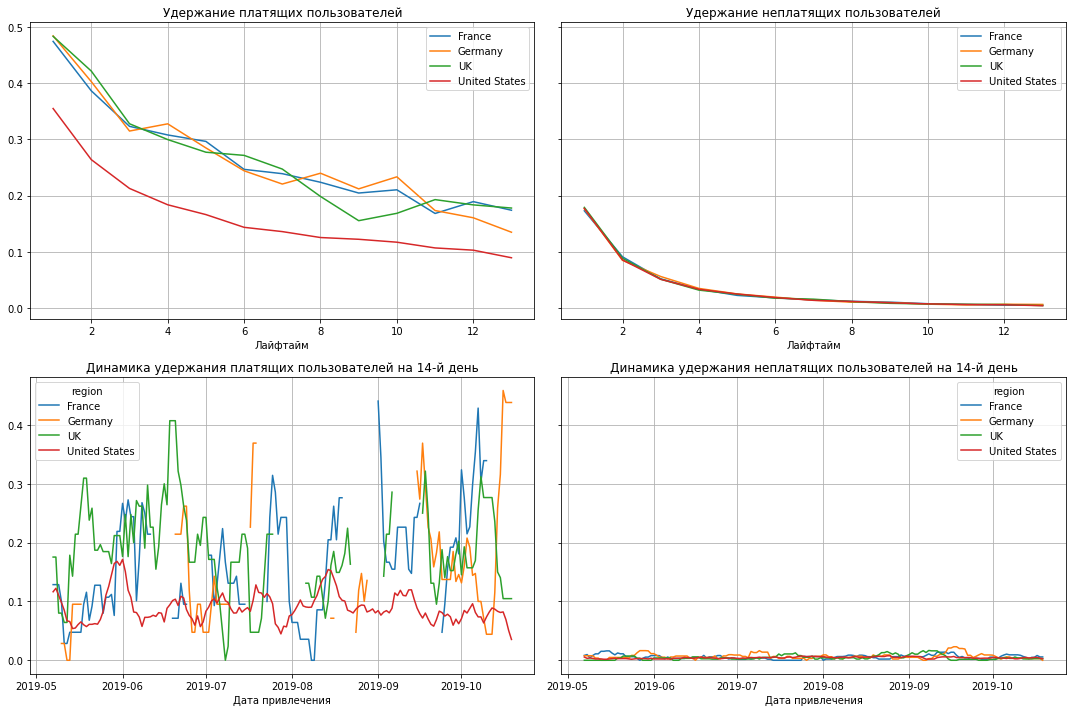

In [114]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
plot_retention(retention, retention_history, horizon_days)

***Вывод***
 - Удержание платящих пользователей хуже всех в США.
 - Удержание неплатящих пользователей почти одинаково у всех стран.
 - Динамика удержания неплатящих поьзователей тоже одинакова у всех стран.

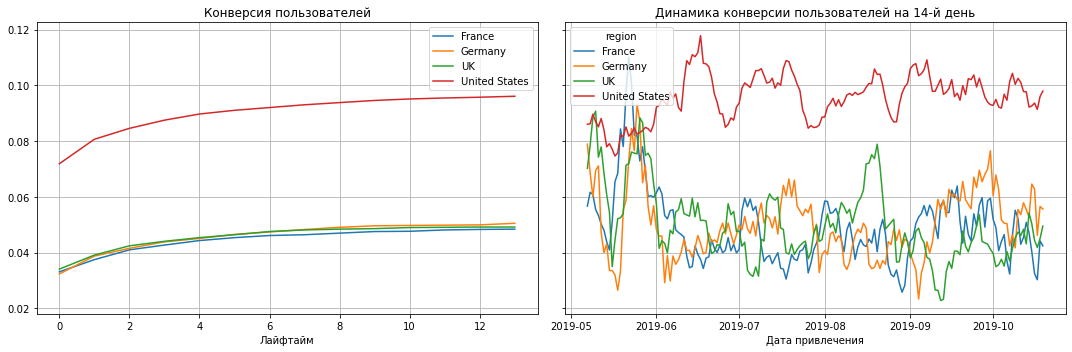

In [115]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days, dimensions=dimensions)
plot_conversion(conversion, conversion_history, horizon_days)

***Вывод***
- Конверсия пользователей выше всех в США
- Конверсия пользователей в остальных странах почти одинаков

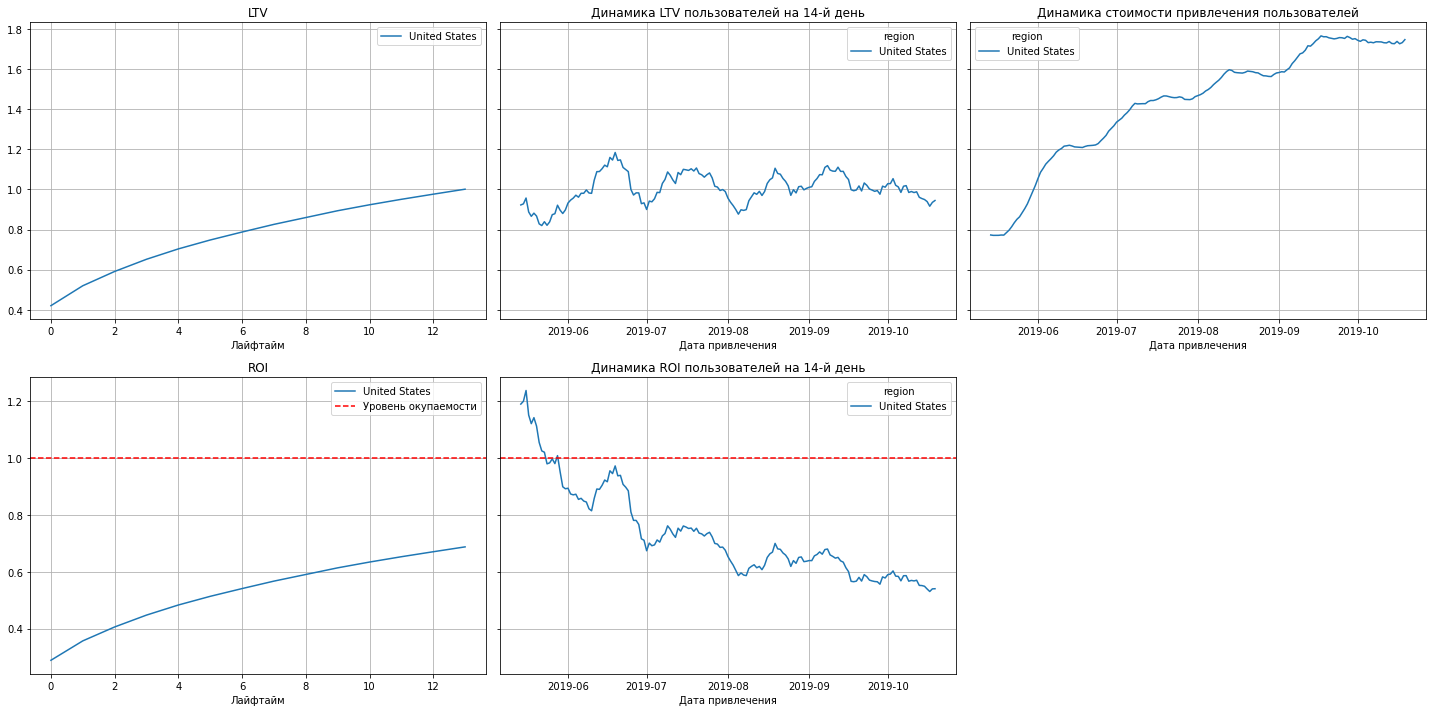

In [116]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['region'] == 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

***Вывод***\
Ситуация в США:
- США не прошла порог окупаемости
- США перестала окупаться в июне
- Динамика стоимости привлечения пользователей с каждым месяцем росла

Разбивка по каналам рекламы

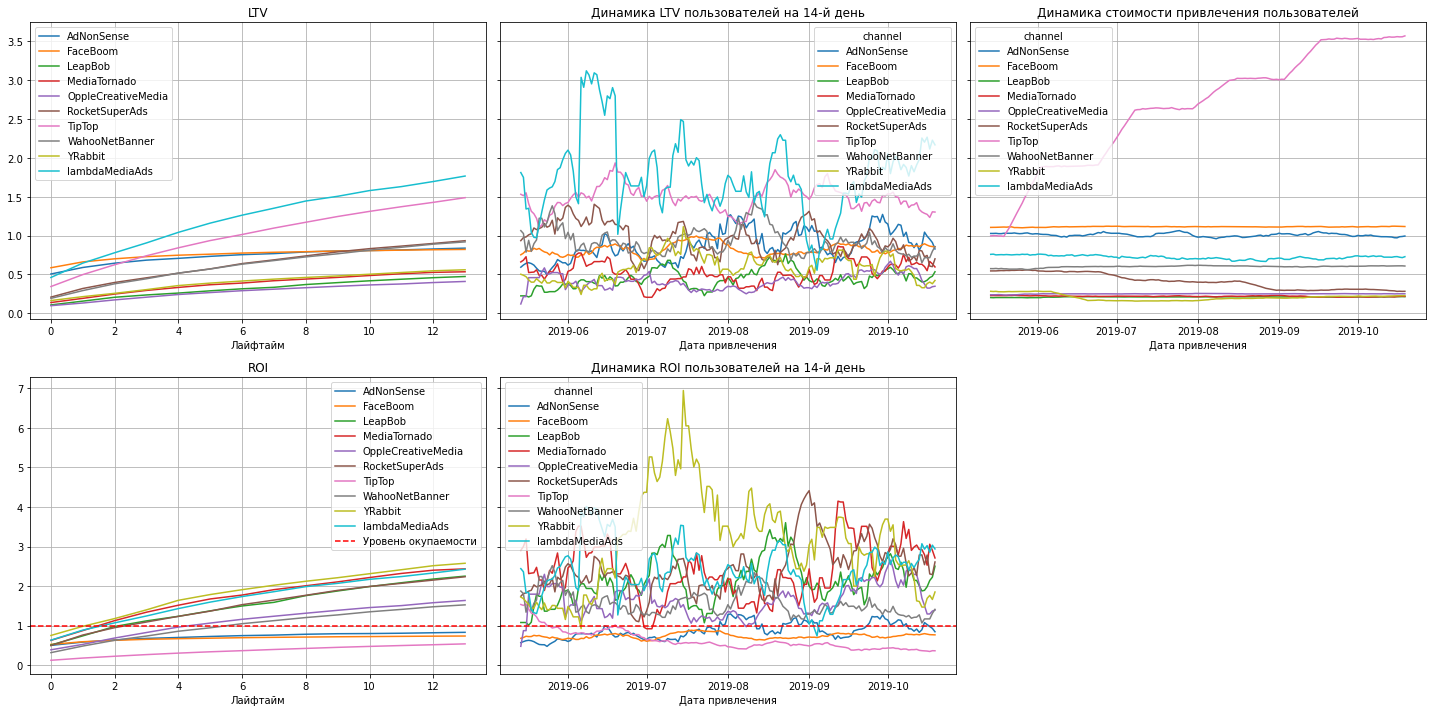

In [117]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

***Вывод***
- У 7 компаний прошла окупаемость, а у трех нет
- Динамика стоимости привлечения пользователей стабильна, кроме компании Tip Top
- LTV стабилен

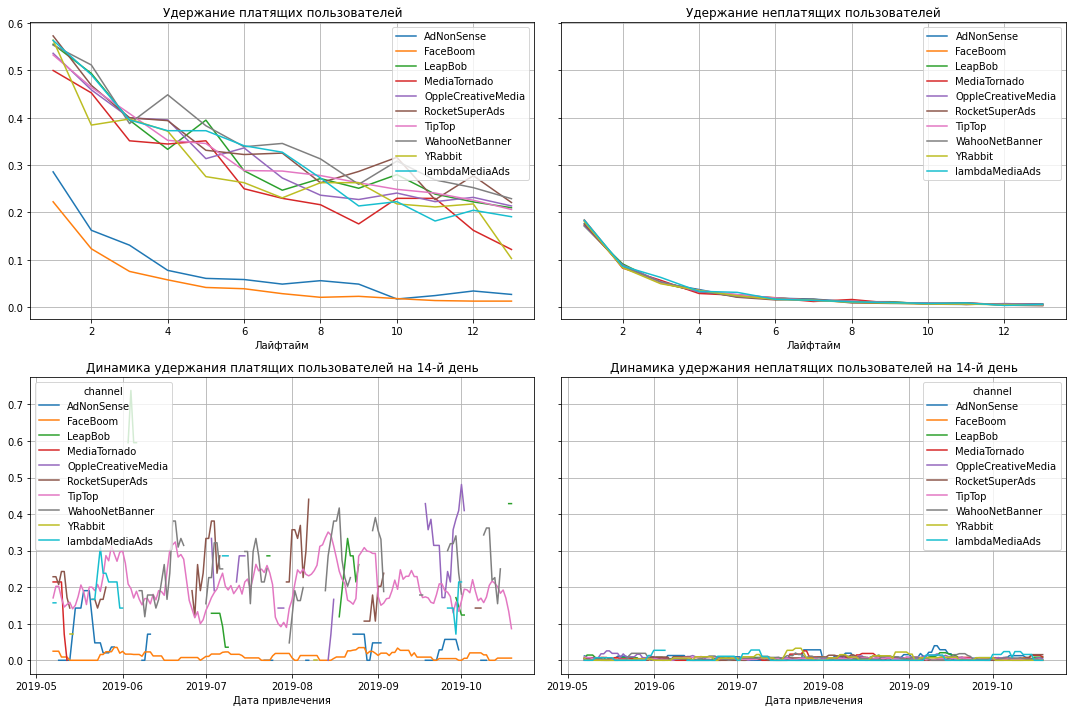

In [118]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
plot_retention(retention, retention_history, horizon_days)

***Вывод***
- Удержание платящих пользователей ниже всего у компаний FaceBoom и AdNonSense (У компании FaceBoom хуже чем у компании AdNonSense)
- Удержание неплатящих пользователей почти одинаково у всех
- Динамика неплатящих пользователей почти одинакова у всех каналов связи
 

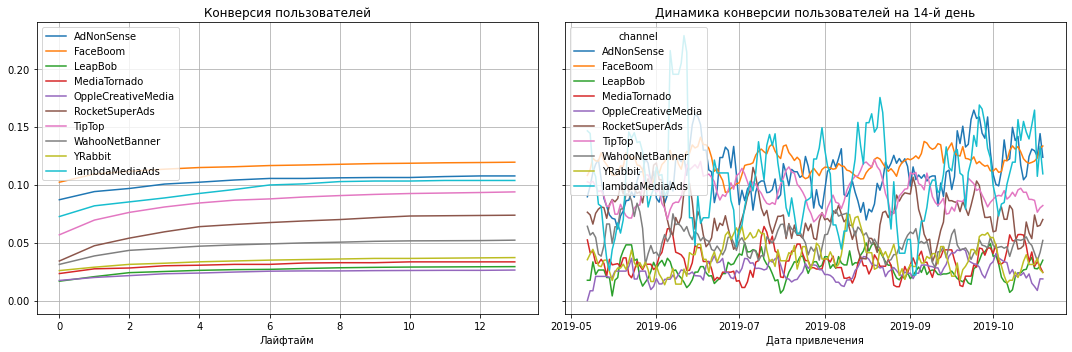

In [119]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date,horizon_days, dimensions=dimensions)
plot_conversion(conversion, conversion_history, horizon_days)

***Вывод***
- Конверсия пользователей выше у всех FaceBoom

***Основные выводы после оценки окупаемости рекламы:***
- Реклама, направленная на привлечение пользователей в целом, не окупается к концу второй недели.
- Устройства "iPhone" и "Mac", страна "США" и рекламные каналы "АdNonSense", "Tip Top", "FaceBoom" могут оказывать негативное влияние на окупаемость рекламы.
- Проблемы с окупаемостью могут быть вызваны неправильным распределением средств на привлечение с каналов

### Вывод

Период, который я рассматривала в проекте, это с 1 мая по 27 октября в 2019 году.

Проведя исследования, я сделала следующие выводы : 
- Больше платящих пользователей из США, чем из Европы
- Больше платящих пользователей используют устройства Mac, iPhone
- Платящие пользователи приходят в большем количестве из каналов связи FaceBoom, AdNonSense

Больше всего расходов и самая большая стоимость привлечения одного клиента у компаний Tip Top, FaceBoom, AdNonSense.\
У канала рекламы TIP TOP очень высокий показатель CAC (конверсии пользователей), это может быть связано с неэффективностью рекламы, тем самым не нужно от него отказаться.\
Компания Procrastinate Pro+ перестает окупаться уже в июле 2019 года. Окупается только на устройстве PC только до сентября.

В США не окупается с июня, хотя динамика стоимости привлечения растет и больше всего платящих пользователей из США.\ Возможные причины:
- 1) Скорее всего произошло какое-то событие в июне 2019 года
- 2) Возникли сложности с установкой приложения на систему IOS и macOS, так как в США большой процент пользоавтелей используют именно Mac, iPhone

Из 10 каналов рекламы окупается только у 7. Не окупаются каналы связи, такие как AdNonSense, TipTop, FaceBoom.

***Возможные причины проблем:***\
Скорее всего проблемы с каналами АdNonSense и FaceBoom связаны с ***неэффективным использованием ресурсов***, тем самым не смотря на достаточно хорошую конверсию люди стали уходить, может по ***причине недовольства контента***. И поэтому удержание платящих клиентов начинает падать на 2 день лайфтайма и стабилизируется только с 8 дня.
Возможно такие проблемы связаны с ***неправильным распределением ресурсов*** на привлечение новых пользователей.

***Предложения маркетологам:***
- 1) Привлекать больше пользователей, которые пользуются устройствами PC, Android
- 2) Обратить внимание на конверсию PC, она достаточно маленькая
- 3) Рассмотретьтакие каналы рекламы, как : 
        - YRabbit( у этой компании самая высокая окупаемость), 
        - MediaTornado, 
        - lambdaMediaAds. 
     У всех этих трех каналов самый большой порог окупаемости.